### This code focuses on the performance of one stock.  Please enter the Securities Code and the number of days you wish to forecast the stock.

In [1]:
# Please enter your choices here
securities_code = 6287
forecast_days=56
input_parameters = 100
epochs=100

# Initial imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import datetime as dt
from datetime import date,timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
# create lists of Japanese Stock Market Holidays (non-weekend)
Japan_Holidays_2019 = ['2019-01-01','2019-01-02','2019-01-03','2019-01-14','2019-02-11', '2019-03-21','2019-04-29','2019-05-03','2019-05-06','2019-07-15','2019-08-12','2019-09-16','2019-09-23', '2019-10-14','2019-11-04','2019-12-31']
Japan_Holidays_2020 = ['2020-01-01', '2020-01-02', '2020-01-03','2020-01-13','2020-02-11','2020-02-24','2020-03-20','2020-04-29','2020-05-04','2020-05-05','2020-05-06','2020-07-23','2020-07-24','2020-08-10','2020-09-21','2020-09-22','2020-11-03','2020-11-23','2020-12-31']
Japan_Holidays_2021 = ['2021-01-01','2021-01-11','2021-02-11','2021-02-23','2021-04-29','2021-05-03','2021-05-04','2021-05-05','2021-07-22','2021-07-23','2021-08-09','2021-09-20','2021-09-23','2021-11-03','2021-11-23','2021-12-31']
Japan_Holidays_2022 = ['2022-01-03','2022-01-10','2022-02-11','2022-02-23','2022-03-21','2022-04-29','2022-05-03','2022-05-04','2022-05-05','2022-07-18','2022-08-11','2022-09-19','2022-09-23','2022-10-10','2022-11-03','2022-11-23']
# concatenate lists
Japan_Holidays = Japan_Holidays_2019+Japan_Holidays_2020+Japan_Holidays_2021+Japan_Holidays_2022
# convert to actual dates 
Japan_Holidays_2019to2022= [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in Japan_Holidays]

In [3]:
# Load the stock prices file
file="./train_files/stock_prices.csv"
stock_df=pd.read_csv(file)
stock_df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [4]:
# check the start and end dates of the stocks
stock_df['Date'].min(),stock_df['Date'].max()

('2017-01-04', '2021-12-03')

In [5]:
# find null values
stock_df[stock_df['Close'].isnull()].isnull().sum()

RowId                  0
Date                   0
SecuritiesCode         0
Open                7608
High                7608
Low                 7608
Close               7608
Volume                 0
AdjustmentFactor       0
ExpectedDividend    7584
SupervisionFlag        0
Target               238
dtype: int64

In [6]:
# remove null values
stock_df.dropna()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
13269,20170116_2590,2017-01-16,2590,6060.0,6130.0,6060.0,6060.0,125800,1.0,30.0,False,0.005051
13726,20170116_4699,2017-01-16,4699,1119.0,1119.0,1081.0,1087.0,11500,1.0,0.0,False,-0.032833
26179,20170125_1928,2017-01-25,1928,1886.0,1894.5,1865.0,1871.5,3310500,1.0,32.0,False,-0.018336
26249,20170125_2217,2017-01-25,2217,515.0,517.0,512.0,512.0,162000,1.0,4.0,False,0.016000
26281,20170125_2353,2017-01-25,2353,153.0,154.0,151.0,152.0,431700,1.0,0.0,False,-0.006452
...,...,...,...,...,...,...,...,...,...,...,...,...
2320290,20211125_8923,2021-11-25,8923,1047.0,1051.0,1030.0,1030.0,389700,1.0,38.0,False,-0.073099
2320357,20211125_9278,2021-11-25,9278,995.0,995.0,989.0,990.0,12800,1.0,0.0,False,0.000000
2320370,20211125_9369,2021-11-25,9369,2000.0,2009.0,1989.0,1990.0,69100,1.0,23.0,False,-0.057692
2320456,20211125_9717,2021-11-25,9717,1258.0,1260.0,1222.0,1223.0,313200,1.0,50.0,False,-0.127517


In [7]:
# create a new df which will only use the "Close" column for predictions
close_df=stock_df[['Date','SecuritiesCode','Close']]
close_df.head()

,Date,SecuritiesCode,Close
0,2017-01-04,1301,2742.0
1,2017-01-04,1332,571.0
2,2017-01-04,1333,3210.0
3,2017-01-04,1376,1550.0
4,2017-01-04,1377,3330.0


In [8]:
# grab just one stock 
one_stock_df=close_df.loc[close_df['SecuritiesCode']==securities_code]
one_stock_df=one_stock_df.dropna()
one_stock_df.reset_index(drop=True, inplace=True)
one_stock_df.head()

,Date,SecuritiesCode,Close
0,2017-01-04,6287,2405.0
1,2017-01-05,6287,2411.0
2,2017-01-06,6287,2413.0
3,2017-01-10,6287,2399.0
4,2017-01-11,6287,2414.0


In [9]:
one_stock_df.head(50)

,Date,SecuritiesCode,Close
0,2017-01-04,6287,2405.0
1,2017-01-05,6287,2411.0
2,2017-01-06,6287,2413.0
3,2017-01-10,6287,2399.0
4,2017-01-11,6287,2414.0
5,2017-01-12,6287,2402.0
6,2017-01-13,6287,2418.0
7,2017-01-16,6287,2379.0
8,2017-01-17,6287,2334.0
9,2017-01-18,6287,2330.0


In [10]:
# convert Date column to datetime 
one_stock_df['Date'] = pd.to_datetime(one_stock_df['Date']).dt.date
one_stock_df.dtypes

Date               object
SecuritiesCode      int64
Close             float64
dtype: object

In [11]:
# only use the Close column for predicting
one_stock_close_df=one_stock_df.reset_index()['Close']
one_stock_close_df.head()

0    2405.0
1    2411.0
2    2413.0
3    2399.0
4    2414.0
Name: Close, dtype: float64

Text(0, 0.5, 'Closing Price (yen)')

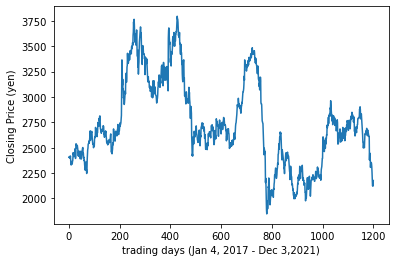

In [12]:
# look at a plot of the close prices for one stock
plt.plot(one_stock_close_df)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")

In [13]:
### LSTM is sensitive to the scale of the data - so we apply MinMax scaler
scaler=MinMaxScaler(feature_range=(0,1))
one_stock_scaler=scaler.fit_transform(np.array(one_stock_close_df).reshape(-1,1))
one_stock_scaler

array([[0.28608115],
       [0.28916281],
       [0.29019004],
       ...,
       [0.14586543],
       [0.14072933],
       [0.16897791]])

In [14]:
# splitting the dataset into train and test splits
training_size=int(len(one_stock_scaler)*0.65)
test_size=len(one_stock_scaler)-training_size
train_data,test_data=one_stock_scaler[0:training_size,:],one_stock_scaler[training_size:len(one_stock_scaler),:1]

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = input_parameters
X_train, y_train=create_dataset(train_data, time_step)
X_test, y_test=create_dataset(test_data, time_step)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [18]:
# Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(int(input_parameters/2),return_sequences=True,input_shape=(input_parameters,1)))
model.add(LSTM(int(input_parameters/2),return_sequences=True))
model.add(LSTM(int(input_parameters/2)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 6s 227ms/step - loss: 0.1440 - val_loss: 0.0159
Epoch 2/100
11/11 [==============================] - 1s 123ms/step - loss: 0.0239 - val_loss: 0.0145
Epoch 3/100
11/11 [==============================] - 1s 117ms/step - loss: 0.0139 - val_loss: 0.0090
Epoch 4/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 5/100
11/11 [==============================] - 1s 118ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 6/100
11/11 [==============================] - 1s 117ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 7/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 8/100
11/11 [==============================] - 1s 118ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 9/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 10/100
11/11 [==============================] - 1s 129ms/step - loss: 0.0057 - val_lo

11/11 [==============================] - 1s 91ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 82/100
11/11 [==============================] - 1s 98ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 83/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 84/100
11/11 [==============================] - 1s 101ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 85/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 86/100
11/11 [==============================] - 1s 115ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 87/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 88/100
11/11 [==============================] - 1s 115ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 89/100
11/11 [==============================] - 1s 116ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 90/100
11/11 [==============================] - 1s 114ms/step - loss: 0.0029 - val_loss: 0.

In [21]:
# prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [22]:
# transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
# calculate RMSE performance metrics
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

3002.9280693243754

In [24]:
# test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

2521.020428140381

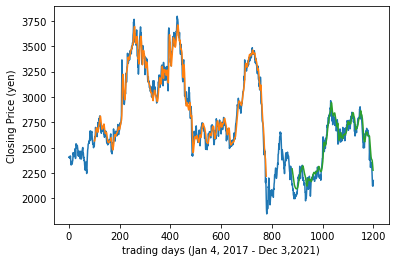

In [25]:
# Plotting
# shift train predictions for plotting
look_back=input_parameters
trainPredictPlot=np.empty_like(one_stock_scaler)
trainPredictPlot[:, :]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
# shift test predictions for plotting
testPredictPlot=np.empty_like(one_stock_scaler)
testPredictPlot[:, :]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(one_stock_scaler)-1,:]=test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(one_stock_scaler))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel("trading days (Jan 4, 2017 - Dec 3,2021)")
plt.ylabel("Closing Price (yen)")
plt.show()

In [26]:
# setup to predict future stock prices
input_start=len(test_data)-input_parameters
x_input=test_data[input_start:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [27]:
# predictions for the amount of forecast days  
from numpy import array

lst_output=[]
n_steps=input_parameters
i=0

while(i<forecast_days):
        if(len(temp_input)>input_parameters):
            x_input=np.array(temp_input[1:])
            print("{} day input  {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input=x_input.reshape((1,n_steps,1))
            yhat=model.predict(x_input,verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
                    

[0.1939798]
101
1 day input  [0.4232152  0.45043657 0.46944016 0.47406266 0.44684129 0.44581407
 0.4375963  0.43091936 0.45814073 0.48176682 0.49460709 0.47765794
 0.48587571 0.48330765 0.51412429 0.50128403 0.50282486 0.49871597
 0.49768875 0.47868516 0.46481767 0.4807396  0.4904982  0.45146379
 0.41705187 0.43656908 0.394453   0.39753467 0.42681048 0.43913713
 0.42989214 0.41910632 0.41140216 0.44016436 0.43451464 0.45146379
 0.4519774  0.48125321 0.48382126 0.48382126 0.48484848 0.48279404
 0.48895737 0.49563431 0.53004622 0.5238829  0.54185927 0.52799178
 0.49152542 0.48022599 0.49922958 0.50590652 0.4853621  0.45865434
 0.4519774  0.41602465 0.39804828 0.36106831 0.35901387 0.33333333
 0.34976888 0.36209553 0.3507961  0.33487417 0.37236775 0.403698
 0.40215716 0.40677966 0.4088341  0.42013354 0.41448382 0.4180791
 0.43297381 0.40472522 0.39958911 0.39548023 0.42475603 0.40010272
 0.40677966 0.40575244 0.39188495 0.39291217 0.3893169  0.27272727
 0.30816641 0.29686697 0.27786338 0.

11 day output [[0.21895093]]
12 day input  [0.47765794 0.48587571 0.48330765 0.51412429 0.50128403 0.50282486
 0.49871597 0.49768875 0.47868516 0.46481767 0.4807396  0.4904982
 0.45146379 0.41705187 0.43656908 0.394453   0.39753467 0.42681048
 0.43913713 0.42989214 0.41910632 0.41140216 0.44016436 0.43451464
 0.45146379 0.4519774  0.48125321 0.48382126 0.48382126 0.48484848
 0.48279404 0.48895737 0.49563431 0.53004622 0.5238829  0.54185927
 0.52799178 0.49152542 0.48022599 0.49922958 0.50590652 0.4853621
 0.45865434 0.4519774  0.41602465 0.39804828 0.36106831 0.35901387
 0.33333333 0.34976888 0.36209553 0.3507961  0.33487417 0.37236775
 0.403698   0.40215716 0.40677966 0.4088341  0.42013354 0.41448382
 0.4180791  0.43297381 0.40472522 0.39958911 0.39548023 0.42475603
 0.40010272 0.40677966 0.40575244 0.39188495 0.39291217 0.3893169
 0.27272727 0.30816641 0.29686697 0.27786338 0.23523369 0.25629173
 0.25526451 0.26040062 0.2547509  0.23985619 0.21109399 0.16795069
 0.14278377 0.14586543

23 day output [[0.25185245]]
24 day input  [0.45146379 0.41705187 0.43656908 0.394453   0.39753467 0.42681048
 0.43913713 0.42989214 0.41910632 0.41140216 0.44016436 0.43451464
 0.45146379 0.4519774  0.48125321 0.48382126 0.48382126 0.48484848
 0.48279404 0.48895737 0.49563431 0.53004622 0.5238829  0.54185927
 0.52799178 0.49152542 0.48022599 0.49922958 0.50590652 0.4853621
 0.45865434 0.4519774  0.41602465 0.39804828 0.36106831 0.35901387
 0.33333333 0.34976888 0.36209553 0.3507961  0.33487417 0.37236775
 0.403698   0.40215716 0.40677966 0.4088341  0.42013354 0.41448382
 0.4180791  0.43297381 0.40472522 0.39958911 0.39548023 0.42475603
 0.40010272 0.40677966 0.40575244 0.39188495 0.39291217 0.3893169
 0.27272727 0.30816641 0.29686697 0.27786338 0.23523369 0.25629173
 0.25526451 0.26040062 0.2547509  0.23985619 0.21109399 0.16795069
 0.14278377 0.14586543 0.14072933 0.16897791 0.1939798  0.19005378
 0.19070201 0.19378178 0.19781703 0.20196038 0.20580314 0.20919783
 0.21213691 0.2146805

35 day output [[0.30344447]]
36 day input  [0.45146379 0.4519774  0.48125321 0.48382126 0.48382126 0.48484848
 0.48279404 0.48895737 0.49563431 0.53004622 0.5238829  0.54185927
 0.52799178 0.49152542 0.48022599 0.49922958 0.50590652 0.4853621
 0.45865434 0.4519774  0.41602465 0.39804828 0.36106831 0.35901387
 0.33333333 0.34976888 0.36209553 0.3507961  0.33487417 0.37236775
 0.403698   0.40215716 0.40677966 0.4088341  0.42013354 0.41448382
 0.4180791  0.43297381 0.40472522 0.39958911 0.39548023 0.42475603
 0.40010272 0.40677966 0.40575244 0.39188495 0.39291217 0.3893169
 0.27272727 0.30816641 0.29686697 0.27786338 0.23523369 0.25629173
 0.25526451 0.26040062 0.2547509  0.23985619 0.21109399 0.16795069
 0.14278377 0.14586543 0.14072933 0.16897791 0.1939798  0.19005378
 0.19070201 0.19378178 0.19781703 0.20196038 0.20580314 0.20919783
 0.21213691 0.21468052 0.21691859 0.21895093 0.22087668 0.22278795
 0.22476605 0.22687832 0.22917712 0.23169875 0.23446468 0.23748246
 0.24074757 0.2442461

47 day output [[0.3528497]]
48 day input  [0.52799178 0.49152542 0.48022599 0.49922958 0.50590652 0.4853621
 0.45865434 0.4519774  0.41602465 0.39804828 0.36106831 0.35901387
 0.33333333 0.34976888 0.36209553 0.3507961  0.33487417 0.37236775
 0.403698   0.40215716 0.40677966 0.4088341  0.42013354 0.41448382
 0.4180791  0.43297381 0.40472522 0.39958911 0.39548023 0.42475603
 0.40010272 0.40677966 0.40575244 0.39188495 0.39291217 0.3893169
 0.27272727 0.30816641 0.29686697 0.27786338 0.23523369 0.25629173
 0.25526451 0.26040062 0.2547509  0.23985619 0.21109399 0.16795069
 0.14278377 0.14586543 0.14072933 0.16897791 0.1939798  0.19005378
 0.19070201 0.19378178 0.19781703 0.20196038 0.20580314 0.20919783
 0.21213691 0.21468052 0.21691859 0.21895093 0.22087668 0.22278795
 0.22476605 0.22687832 0.22917712 0.23169875 0.23446468 0.23748246
 0.24074757 0.24424617 0.24795662 0.25185245 0.25590405 0.26008072
 0.26435208 0.26868984 0.27306792 0.27746412 0.28185961 0.28623983
 0.29059395 0.29491481

Text(0, 0.5, 'Closing Price (yen)')

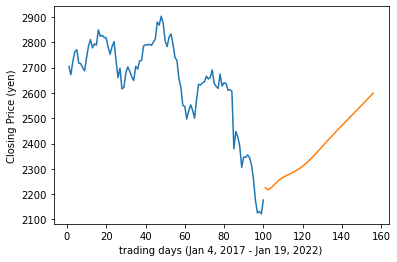

In [28]:
# see how our predictions add on to the end of closing stock prices
day_new=np.arange(1,101)
day_pred=np.arange(101,101+forecast_days)
days_end=len(one_stock_scaler)-100
plt.plot(day_new,scaler.inverse_transform(one_stock_scaler[days_end:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("trading days (Jan 4, 2017 - Jan 19, 2022)")
plt.ylabel("Closing Price (yen)")

In [29]:
# create a new df with predictions
predicted_one_stock_df=one_stock_df.copy()
predicted_scalar=scaler.inverse_transform(lst_output)
predicted_values=predicted_scalar.tolist()
total_days=len(one_stock_df)
new_date=one_stock_df['Date'][total_days-1]
security_code=one_stock_df['SecuritiesCode'][0]

for count,value in enumerate(predicted_values):
    new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    while new_date.weekday()==5 or new_date.weekday()==6 or new_date.date() in Japan_Holidays_2019to2022:
        new_date=pd.to_datetime(new_date+dt.timedelta(days=1))
    predicted_one_stock_df.loc[len(predicted_one_stock_df.index)] = [new_date.date(), security_code, value[0]]                 

In [30]:
# make certain prediction days are added with no repeat dates or weekend days
predicted_one_stock_df.tail(56)

,Date,SecuritiesCode,Close
1201,2021-12-06,6287,2225.678670
1202,2021-12-07,6287,2218.034702
1203,2021-12-08,6287,2219.296806
1204,2021-12-09,6287,2225.293122
1205,2021-12-10,6287,2233.149753
1206,2021-12-13,6287,2241.216869
1207,2021-12-14,6287,2248.698716
1208,2021-12-15,6287,2255.308183
1209,2021-12-16,6287,2261.030563
1210,2021-12-17,6287,2265.982978


Text(0, 0.5, 'Closing Price (yen)')

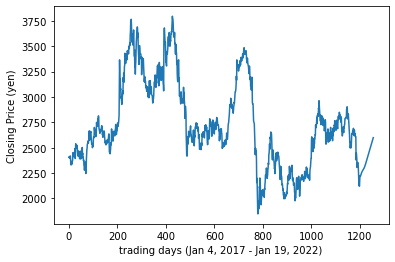

In [31]:
# look at a plot of the close prices for one stock including forecast day predictions
plt.plot(predicted_one_stock_df['Close'])
plt.xlabel("trading days (Jan 4, 2017 - Jan 19, 2022)")
plt.ylabel("Closing Price (yen)")

In [32]:
# write close price predictions_df to a csv file
filepath="TSE6287.csv"
predicted_one_stock_df.to_csv(filepath,index=False)